In [1]:
import os.path as op
import os
# import sys
import numpy as np
import pandas as pd
import seaborn as sns
from fpdf import FPDF  

import mne
import matplotlib.pyplot as plt
# from mne.time_frequency import psd_multitaper
import scipy.stats

## Preprocessing

In [2]:
# data_path =  'D:\projects\WM_GRID\DATA\mg99a'
# cal_path = 'D:\projects\WM_GRID\DATA\ctc'
# sss_path = 'D:\projects\WM_GRID\DATA\sss'

rawdir =  '/data/pt_02783/memory_grid/rawdir/'
# cal_path = '/data/pt_02783/ctc'
# sss_path = '/data/pt_02783/sss'

subject_list = ['mg01']
subject_id = subject_list[0]
data_path = os.path.join(rawdir,subject_id+'a')
file_exts = ['%sa01',
                     '%sa02',
                     '%sa03',
                     '%sa04',
                     '%sa05',
                     '%sa06',
                     '%sb07',
                     '%sb08',
                     '%sb09',
                     '%sb10',
                     '%sb11',
                     '%sb12']#,

file_names = [f % (subject_id) for f in file_exts]
out_path = op.join(data_path, "out_path")
noreject_path = op.join(out_path,"noreject_path")    
file_name = (subject_id+"a01")
fname_epo = op.join(noreject_path,
                            file_name + 'ALL_epo.fif')
epochs =  mne.read_epochs(fname_epo,
                          preload = True,
                          verbose = True)

Reading /data/pt_02783/memory_grid/rawdir/mg01a/out_path/noreject_path/mg01a01ALL_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    8100.00 ms
        0 CTF compensation matrices available
Reading /data/pt_02783/memory_grid/rawdir/mg01a/out_path/noreject_path/mg01a01ALL_epo-1.fif ...
    Found the data of interest:
        t =    -500.00 ...    8100.00 ms
        0 CTF compensation matrices available
Reading /data/pt_02783/memory_grid/rawdir/mg01a/out_path/noreject_path/mg01a01ALL_epo-2.fif ...
    Found the data of interest:
        t =    -500.00 ...    8100.00 ms
        0 CTF compensation matrices available
Reading /data/pt_02783/memory_grid/rawdir/mg01a/out_path/noreject_path/mg01a01ALL_epo-3.fif ...
    Found the data of interest:
        t =    -500.00 ...    8100.00 ms
        0 CTF compensation matrices available
Not setting metadata
720 matching events found
No baseline correction applied
0 projection items activated


In [20]:
epochs.info

<Info | 23 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: MEG0113, MEG0112, MEG0111, MEG0122, MEG0123, MEG0121, MEG0132, ...
 chs: 204 Gradiometers, 102 Magnetometers, 1 misc, 3 Stimulus
 custom_ref_applied: False
 description: vectorview system
 dev_head_t: MEG device -> head transform
 dig: 658 items (3 Cardinal, 5 HPI, 650 Extra)
 events: 1 item (list)
 experimenter: MEG guest (megguest)
 file_id: 4 items (dict)
 highpass: 1.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 3 items (dict)
 line_freq: 50.0
 lowpass: 100.0 Hz
 meas_date: 2023-05-04 07:10:20 UTC
 meas_id: 4 items (dict)
 nchan: 310
 proc_history: 1 item (list)
 proj_id: 1 item (ndarray)
 proj_name: visual
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 3 items (dict)
>

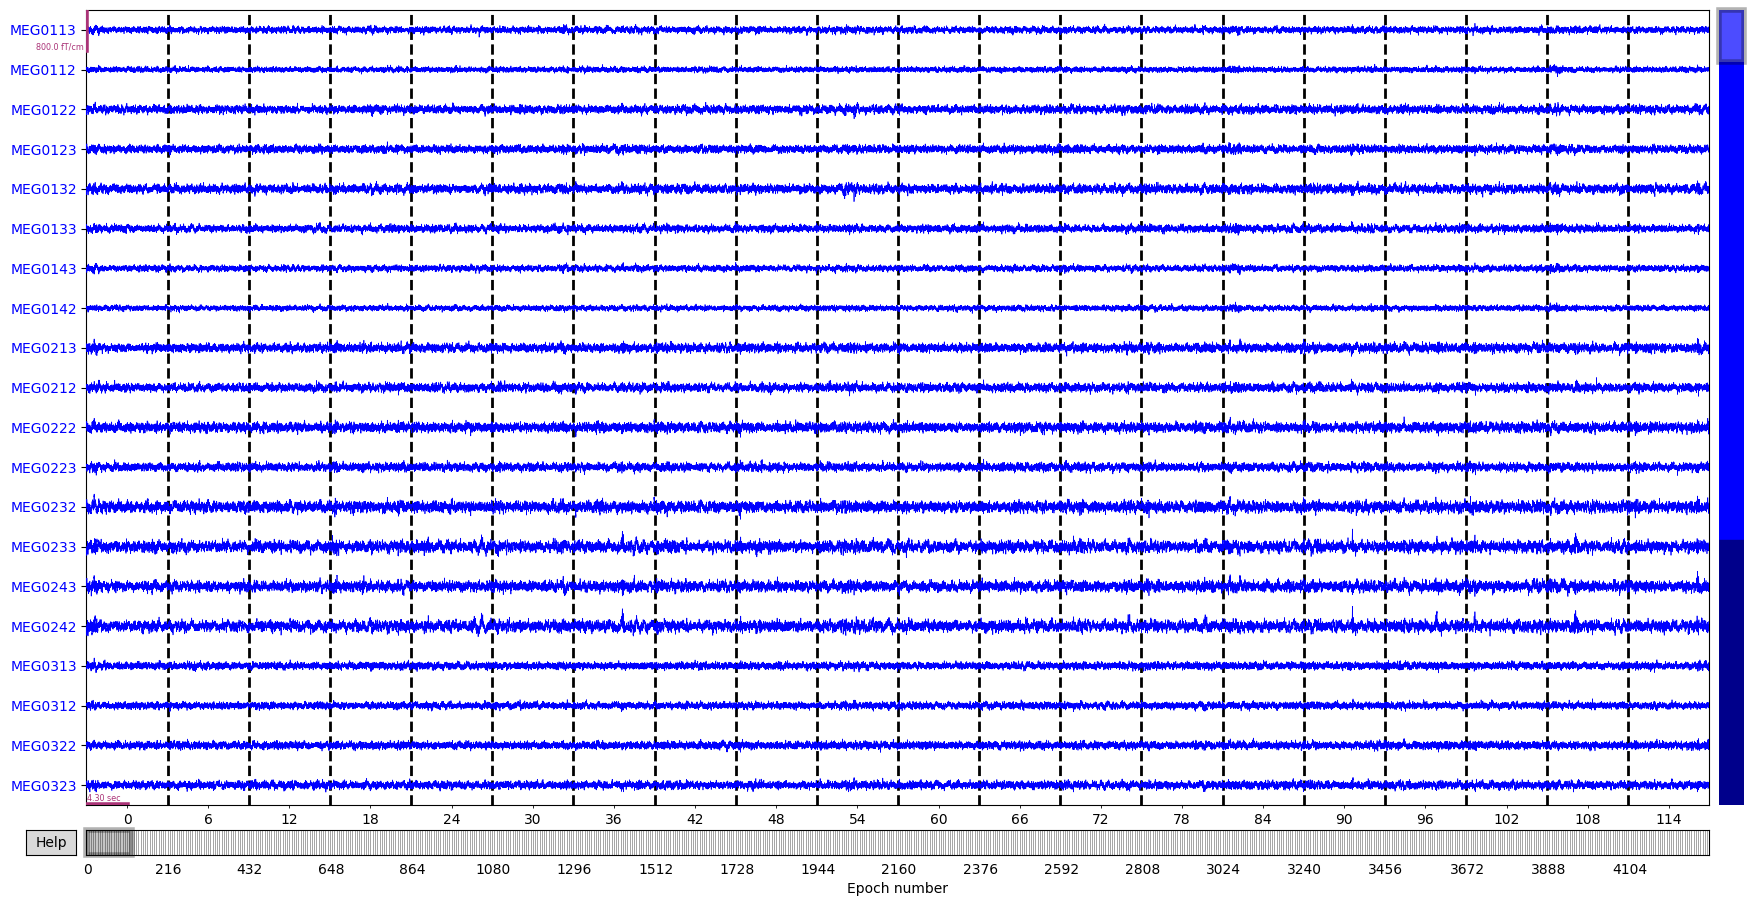

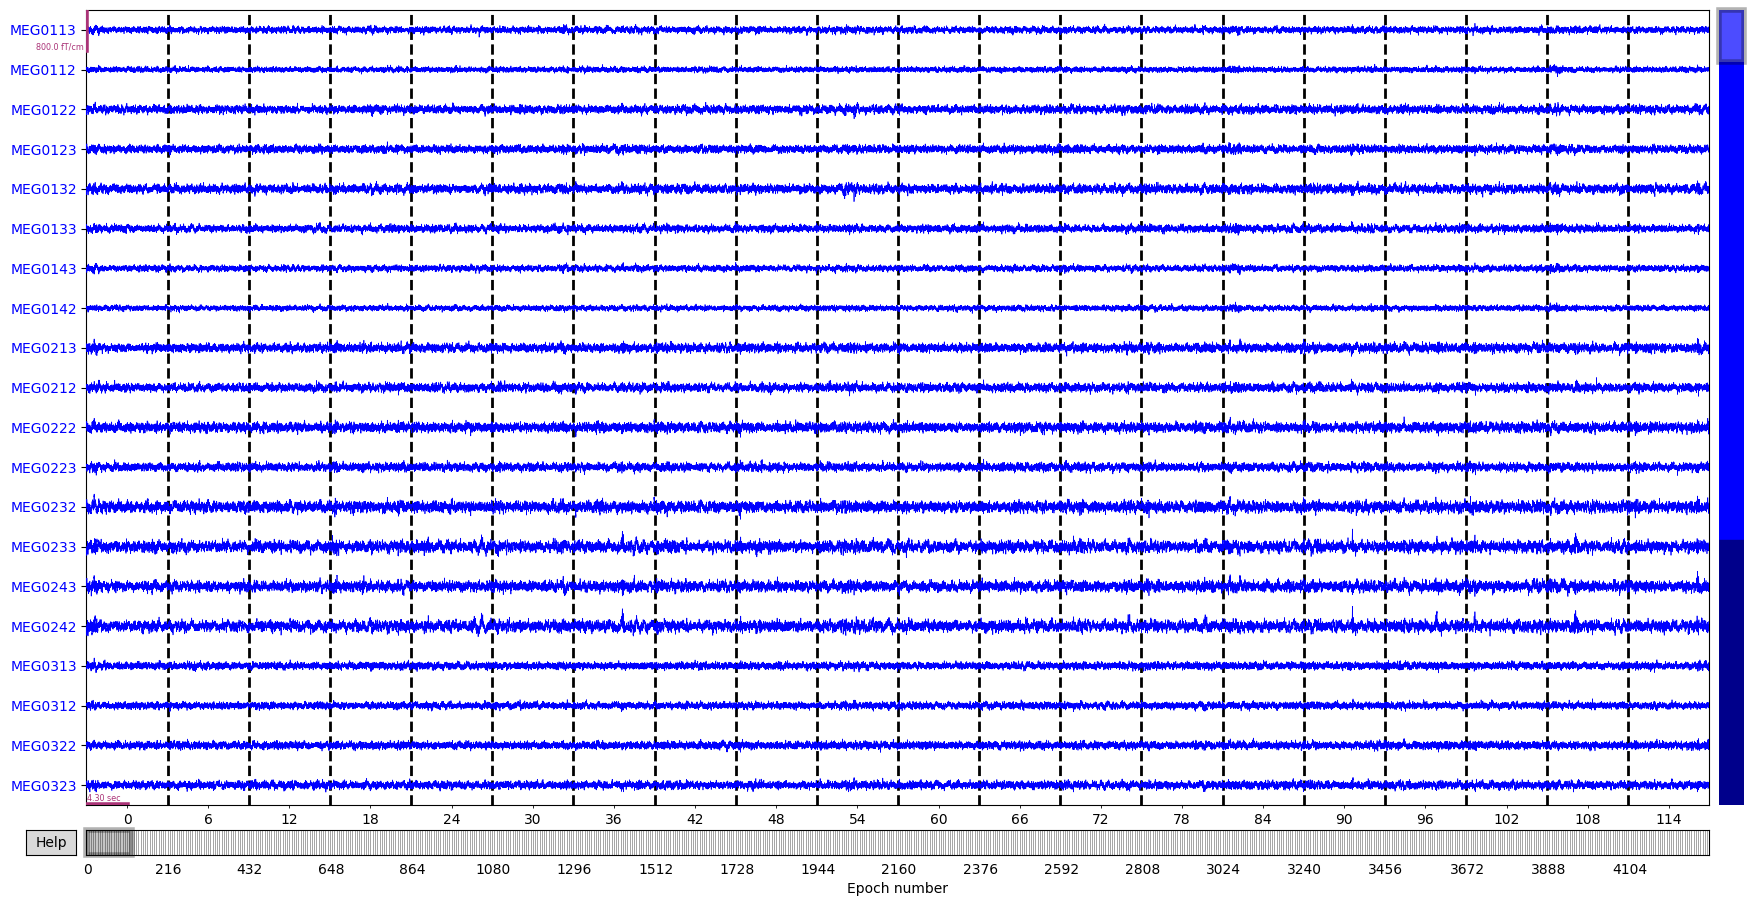

In [17]:
%matplotlib inline

epochs.plot()

In [12]:
file_name = (subject_id+"a01")
file_name

'mg01a01'

In [3]:
subject_list[:]

['mg01']

In [ ]:
# %load 01-maxwell_filtering.py
"""
===================================
01. Maxwell filter using MNE-python
===================================

The data are Maxwell filtered using tSSS/SSS.

It is critical to mark bad channels before Maxwell filtering.

Open issues:
    1. SSS or tSSS? -> Consult Alex G.?
    
"""  # noqa: E501


def run_maxwell_filter(method = 'sss'):

    crosstalk_file = op.join(cal_path, "ct_sparse.fif")
    fine_cal_file = op.join(sss_path, "sss_cal.dat")

    # Create empty dataframe for bad channel list
    df = pd.DataFrame()
    
    # Prepare PDF report
    pdf = FPDF(orientation="P", unit="mm", format="A4")
    
    print("Processing subject: %s" % subject_id)
    run = 0
    for file_name in file_names:
        run = run + 1
        print("  File: %s" % file_name)
        
        # Read raw data
        raw_fname_in = op.join(data_path, file_name + '.fif')
        raw = mne.io.read_raw_fif(
            raw_fname_in,
            allow_maxshield=True,
            preload=False,
            verbose=True)
        
        # Detect bad channels
        raw.info['bads'] = ['MEG0712','MEG1241','MEG2641']
        raw_check = raw.copy()
        auto_noisy_chs, auto_flat_chs, auto_scores = find_bad_channels_maxwell(
            raw_check, 
            cross_talk=crosstalk_file, 
            calibration=fine_cal_file,
            return_scores=True,
            verbose=True)
        raw.info['bads'].extend(auto_noisy_chs + auto_flat_chs)
        
        # Append bad channels to the list 
        df = df.append({'run': run,
                        'noisy': auto_noisy_chs, 
                        'flat': auto_flat_chs},
                        ignore_index=True)        
        
        # Visualize the scoring used to classify channels as noisy or flat
        ch_type = 'grad'
        fig = viz_badch_scores(auto_scores, ch_type)
        fname_fig = op.join(out_path,
                            "01_r%s_badchannels_%sscore.png" % (run,ch_type))
        fig.savefig(fname_fig)
        plt.close()
        ch_type = 'mag'
        fig = viz_badch_scores(auto_scores, ch_type)
        fname_fig = op.join(out_path,
                            "01_r%s_badchannels_%sscore.png" % (run,ch_type))
        fig.savefig(fname_fig)
        plt.close()
        
        # Fix Elekta magnetometer coil types
        raw.fix_mag_coil_types()
        # realign
        file_name_ref=file_names[0]
        raw_ref_fname_in = op.join(data_path, file_name_ref + '.fif')
        raw_ref = mne.io.read_raw_fif(raw_ref_fname_in,
            allow_maxshield=True,
            preload=False,
            verbose=True)
        dev_head_t_ref = raw_ref.info['dev_head_t']
        
        # Perform tSSS/SSS and Maxwell filtering
        raw_sss = mne.preprocessing.maxwell_filter(
            raw,
            origin='auto',
            cross_talk=crosstalk_file,
            calibration=fine_cal_file,
            st_duration=st_duration,
            coord_frame='head',
            destination=dev_head_t_ref,
            #coord_frame="meg", #only for empy room, comment it if using HPI
            verbose=True)
        
        # Show original and filtered signals
        fig = raw.copy().pick(['meg']).plot(duration=5,
                                            start=100,
                                            butterfly=True)        
        fname_fig = op.join(out_path,
                            '01_r%s_plotraw.png' % run)
        fig.savefig(fname_fig)
        plt.close()
        fig = raw_sss.copy().pick(['meg']).plot(duration=5,
                                                start=100,
                                                butterfly=True)
        fname_fig = op.join(out_path,
                            '01_r%s_plotraw%s.png' % (run,method))
        fig.savefig(fname_fig)
        plt.close()
        
        # Show original and filtered power
        fig1 = raw.plot_psd(picks = ['meg'],fmin = 1,fmax = 100)
        fname_fig1 = op.join(out_path,
                            '01_r%s_plot_psd_raw100.png' % run)
        fig1.savefig(fname_fig1)
        plt.close()
        fig2 = raw_sss.plot_psd(picks = ['meg'],fmin = 1,fmax = 100)
        fname_fig2 = op.join(out_path,
                            '01_r%s_plot_psd_raw100%s.png' % (run,method))
        fig2.savefig(fname_fig2)
        plt.close()
        
        '''
        # Add figures to report
        pdf.add_page()
        pdf.set_font('helvetica', 'B', 16)
        pdf.cell(0, 10, file_name)
        pdf.ln(20)
        pdf.set_font('helvetica', 'B', 12)
        pdf.cell(0, 10, 'Power Spectrum of Raw MEG Data', 'B', ln=1)
        pdf.image(fname_fig1, 0, 45, pdf.epw)
        pdf.ln(120)
        pdf.cell(0, 10, 'Power Spectrum of Filtered MEG Data', 'B', ln=1)
        pdf.image(fname_fig2, 0, 175, pdf.epw)
        '''
        # Save filtered data
        fname_out = op.join(out_path,
                            file_name + '_' + method + '.fif')
        raw_sss.save(fname_out, overwrite=True)
        
    # Save bad channel list
    df.to_csv(op.join(out_path,
                      '01_rAll_meg_badch_list.csv'),
              index=False)
    
    # Save report
    # pdf.output(op.join(out_path,
    #                  'run_maxwell_filter' + '-report.pdf'))
    
    # sys.stdout.close()      # close log file
    # sys.stdout = stdout_obj # restore command prompt


def viz_badch_scores(auto_scores, ch_type):
    fig, ax = plt.subplots(1, 4, figsize=(12, 8))
    fig.suptitle(f'Automated noisy/flat channel detection: {ch_type}',
                  fontsize=16, fontweight='bold')
    
    #### Noisy channels ####
    ch_subset = auto_scores['ch_types'] == ch_type
    ch_names = auto_scores['ch_names'][ch_subset]
    scores = auto_scores['scores_noisy'][ch_subset]
    limits = auto_scores['limits_noisy'][ch_subset]
    bins = auto_scores['bins']  #the windows that were evaluated
    
    # Label each segment by its start and stop time (3 digits / 1 ms precision)
    bin_labels = [f'{start:3.3f} – {stop:3.3f}' 
                  for start, stop in bins]
    
    # Store  data in DataFrame
    data_to_plot = pd.DataFrame(data=scores,
                                columns=pd.Index(bin_labels, name='Time (s)'),
                                index=pd.Index(ch_names, name='Channel'))
    
    # First, plot the raw scores
    sns.heatmap(data=data_to_plot, 
                cmap='Reds', 
                cbar=False,
                # cbar_kws=dict(label='Score'),
                ax=ax[0])
    [ax[0].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[0].set_title('Noisy: All Scores', fontweight='bold')

    # Second, highlight segments that exceeded the 'noisy' limit
    sns.heatmap(data=data_to_plot,
                vmin=np.nanmin(limits),
                cmap='Reds', 
                cbar=True, 
                # cbar_kws=dict(label='Score'), 
                ax=ax[1])
    [ax[1].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[1].set_title('Noisy: Scores > Limit', fontweight='bold')
    
    #### Flat channels ####
    ch_subset = auto_scores['ch_types'] == ch_type
    ch_names = auto_scores['ch_names'][ch_subset]
    scores = auto_scores['scores_flat'][ch_subset]
    limits = auto_scores['limits_flat'][ch_subset]
    bins = auto_scores['bins']  #the windows that were evaluated
    
    # Label each segment by its start and stop time (3 digits / 1 ms precision)
    bin_labels = [f'{start:3.3f} – {stop:3.3f}' 
                  for start, stop in bins]
    
    # Store  data in DataFrame
    data_to_plot = pd.DataFrame(data=scores,
                                columns=pd.Index(bin_labels, name='Time (s)'),
                                index=pd.Index(ch_names, name='Channel'))
    
    # First, plot the raw scores
    sns.heatmap(data=data_to_plot, 
                cmap='Reds', 
                cbar=False,
                # cbar_kws=dict(label='Score'),
                ax=ax[2])
    [ax[2].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[2].set_title('Flat: All Scores', fontweight='bold')

    # Second, highlight segments that exceeded the 'noisy' limit
    sns.heatmap(data=data_to_plot,
                vmax=np.nanmax(limits),
                cmap='Reds', 
                cbar=True,
                # cbar_kws=dict(label='Score'), 
                ax=ax[3])
    [ax[3].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[3].set_title('Flat: Scores > Limit', fontweight='bold')
    
    # Fit figure title to not overlap with the subplots
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    return fig

In [ ]:
# %load 02 filter_downsample.py
def filter_downsample():
    
    # stdout_obj = sys.stdout                 # store original stdout 
    # sys.stdout = open(op.join(out_path,     # open log file
    #                           os.path.basename(__file__) + "_%s.txt" % (site_id+subject_id)),'w')
    print('\n\n\n\n\n#######################################################################################')
    print("Processing subject: %s" % subject_id)
    run = 0
    for file_name in file_names:
        run = run + 1
        print("  File: %s" % file_name)
        
        # Read raw data
        raw_fname_in = op.join(out_path,
                               file_name + '_sss.fif')
        raw = mne.io.read_raw_fif(
            raw_fname_in, 
            preload=True, 
            verbose='error')
        
        # Downsample copy of raw
        raw_resmpl = raw.copy()
        # Band-pass filter raw copy
        raw_resmpl.filter(1, 100)
        raw_resmpl.notch_filter([50])
        # Save filtered data
        fname_out = op.join(out_path,
                            file_name  + '_filter.fif')
        raw_resmpl.save(fname_out, overwrite=True)
        
    


In [ ]:
raw_fname_in=op.join(out_path,'mg99a01'+ 'filter.fif')
raw=mne.io.read_raw_fif(raw_fname_in, preload=True, verbose='error')
%matplotlib qt
raw.copy().plot(duration=5,start=100)

In [ ]:
# %load 03-run_ica.py
"""
===========
03. Run ICA
===========

Open issues:
    1. why the EEG-specific ICA gives only a few components?
    
"""


def run_ica(max_iter = 100, n_components = 0.99, random_state = 1):
    
    # stdout_obj = sys.stdout                 # store original stdout 
    # sys.stdout = open(op.join(out_path,     # open log file
    #                           os.path.basename(__file__) + "_%s.txt" % (site_id+subject_id)),'w')
    print('\n\n\n\n\n#######################################################################################')
    print("Processing subject: %s" % subject_id)
    run = 0
    for file_name in file_names:
        run = run + 1
        print("  File: %s" % file_name)
        
        # Read raw data
        raw_fname_in = op.join(out_path,
                               file_name + '_filter.fif')
        raw = mne.io.read_raw_fif(
            raw_fname_in, 
            preload=True, 
            verbose='error')
        
        # Downsample copy of raw
        raw_resmpl = raw.copy().resample(sfreq)
            
        # Band-pass filter raw copy
        raw_resmpl.filter(l_freq, h_freq)
            
        # Concatenate raw copies
        if run == 1:
            raw_resmpl_all = mne.io.concatenate_raws([raw_resmpl])
        else:
            raw_resmpl_all = mne.io.concatenate_raws([raw_resmpl_all, raw_resmpl])
        
        del raw, raw_resmpl
    
    ###################
    # ICA on MEG data #
    ###################
    
    # Prepare PDF report
    pdf = FPDF(orientation="P", unit="mm", format="A4")
    
    # Define ICA settings
    ica = ICA(method=ica_method,
              random_state=random_state,
              n_components=n_components,
              verbose=True)
    
    # Run ICA on filtered raw data
    ica.fit(raw_resmpl_all,
            picks='meg',
            verbose=True)
    
    # Plot timecourse of estimated sources
    fig = ica.plot_sources(raw_resmpl_all,
                           start=100,
                           show_scrollbars=False,
                           title='ICA_MEG')
    
    # for i in range(len(fig)):
    #     fname_fig = op.join(out_path, 
    #                         '05_rAll_ica_meg_src%d' % i)
    #     fig[i].savefig(fname_fig)
    #     plt.close(fig[i])

    fname_fig = op.join(out_path, 
                      "05_rAll_ica_meg_src.png")
    fig.savefig(fname_fig)
    plt.close(fig)
    
    '''
    # Add figure to report
    pdf.add_page()
    pdf.set_font('helvetica', 'B', 16)
    pdf.cell(0, 10, file_names[0][0:13] + ' - MEG')
    pdf.ln(20)
    pdf.set_font('helvetica', 'B', 12)
    pdf.cell(0, 10, 'Timecourse of MEG ICs', 'B', ln=1)
    pdf.image(fname_fig, 0, 45, pdf.epw)
    '''
    # Project mixing matrix on interpolated sensor topography
    fig = ica.plot_components(title='ICA_MEG')
    for i in range(len(fig)):
        fname_fig = op.join(out_path, 
                            '05_rAll_ica_meg_cmp%d.png' % i)
        fig[i].savefig(fname_fig)
        plt.close(fig[i])
        
        '''
        # Add figure to report
        pdf.add_page()
        pdf.set_font('helvetica', 'B', 16)
        pdf.cell(0, 10, file_names[0][0:13] + ' - MEG')
        pdf.ln(20)
        pdf.set_font('helvetica', 'B', 12)
        pdf.cell(0, 10, 'Topography of MEG ICs', 'B', ln=1)
        pdf.image(fname_fig, 0, 45, pdf.epw)
        
        '''
    # Save files
    ica_fname = op.join(out_path,
                        subject_id + 'ALL-ica_meg.fif')
    ica.save(ica_fname)
    
    # Save report
    # pdf.output(op.join(out_path,
    #                   'run_ica' + '-reportMEG.pdf'))


In [ ]:
# %load 04-extract_events.py
"""
===================
04. Extract events
===================

Extract events from the stimulus channel

Open issues:
    - metadata for exp 2 needs to be created

"""


def run_events():
    
    # stdout_obj = sys.stdout                 # store original stdout 
    # sys.stdout = open(op.join(out_path,     # open log file
                              # os.path.basename(__file__) + "_%s.txt" % (site_id+subject_id)),'w')
    
    # Prepare PDF report
    pdf = FPDF(orientation="P", unit="mm", format="A4")

    print("Processing subject: %s" % subject_id)
    run = 0
    for file_name in file_names:
        run = run + 1
        print("  File: %s" % file_name)
        
        # Read raw data
        run_fname = op.join(data_path,
                            file_name + '.fif')
        raw = mne.io.read_raw_fif(
            run_fname,
            allow_maxshield=True,
            verbose=True)
        
        ###############
        # Read events #
        ###############
    
        
        # Find all events
        events = mne.find_events(raw,
                                 stim_channel='STI101',
                                 consecutive = True,
                                 min_duration=0.001001,
                                 mask = 65280,
                                 mask_type = 'not_and'
                                )
        events = events[events[:,2] != 255]
        
        # Concatenate all events
        events = np.concatenate([events],axis = 0)
        events = events[events[:,0].argsort(),:]
        
        # Show events
        fig = mne.viz.plot_events(events)
        fname_fig = op.join(out_path,
                            "04_r%s_events.png" % run)
        fig.savefig(fname_fig)
        plt.close(fig)
        
        '''
        # Add figure to report
        pdf.add_page()
        pdf.set_font('helvetica', 'B', 16)
        pdf.cell(0, 10, file_name)
        pdf.ln(20)
        pdf.set_font('helvetica', 'B', 12)
        pdf.cell(0, 10, 'Events', 'B', ln=1)
        pdf.image(fname_fig, 0, 45, pdf.epw)
        '''
        # Save event array
        fname_events = op.join(out_path,
                               file_name + '-eve.fif')                            
        mne.write_events(fname_events, events)
        
    # Save report
    # pdf.output(op.join(out_path,
    #                   'run_events' + '-report.pdf'))


In [ ]:
# %load config.py
"""
===========
Config file
===========

Configurate the parameters of the study.
"""
for subject_id in subject_list[:]:

    # =============================================================================
    # SESSION-SPECIFIC SETTINGS
    # =============================================================================

    # Set filename based on experiment number
    data_path = os.path.join(rawdir,subject_id+'a')
    file_exts = ['%sa01',
                     '%sa02',
                     '%sa03',
                     '%sa04',
                     '%sa05',
                     '%sa06',
                     '%sb07',
                     '%sb08',
                     '%sb09',
                     '%sb10',
                     '%sb11',
                     '%sb12']

    file_names = [f % (subject_id) for f in file_exts]


    # =============================================================================
    # GENERAL SETTINGS
    # =============================================================================

    # Set out_path folder or create it if it doesn't exist
    out_path = op.join(data_path, "out_path")
    if not op.exists(out_path):
        os.mkdir(out_path)


    # =============================================================================
    # MAXWELL FILTERING SETTINGS
    # =============================================================================

    # Set filtering method
    method='sss'
    if method == 'tsss':
        st_duration = 10
    else:
        st_duration = None


    # =============================================================================
    # FILTERING AND DOWNSAMPLING SETTINGS
    # =============================================================================

    # Filter and resampling params
    l_freq = 1
    h_freq = 40
    sfreq = 200


    # =============================================================================
    # ICA SETTINGS
    # =============================================================================

    ica_method = 'fastica'
    n_components = 0.99
    max_iter = 800
    random_state = 1688


    # =============================================================================
    # RUN
    # =============================================================================

    # run_maxwell_filter(method=method)

    filter_downsample()

    # artifact_annotation()

    
    # run_ica(max_iter = max_iter, 
    #        n_components = n_components, 
    #        random_state = random_state)
    
    # run_events()

In [ ]:
# %load 05-apply_ica.py
"""
===============
05. Apply ICA
===============

This relies on the ICAs computed in 05-run_ica.py

Open issues:
    1. Should we automitaze EOG- and ECG-related ICs detection?
    -> up to Ling and Oscar. Do auto and cross-check afterwards
    2. Add plots?
    -> no
    3. How many comps per type should we remove?
    -> 1-2 each (if any). 2-5 in total
    4. Apply on concatenated data? -> Yes
    
"""

def apply_ica(meg_ica_eog = [], meg_ica_ecg = []):

    # Prepare PDF report
    pdf = FPDF(orientation="P", unit="mm", format="A4")
    
    print("Processing subject: %s" % subject_id)
    run = 0
    for file_name in file_names:
        run = run + 1
        print("  File: %s" % file_name)
        
        # Read raw data
        raw_fname_in = op.join(out_path,
                               file_name + '_filter.fif')
        raw = mne.io.read_raw_fif(
            raw_fname_in, 
            preload=True, 
            verbose='error')
        
        # Show original signal

        chs = ['MEG0311', 'MEG0121', 'MEG1211', 'MEG1411']
        chan_idxs = [raw.ch_names.index(ch) for ch in chs]
        fig1 = raw.plot(order=chan_idxs,
                       duration=50,
                       start=100)        
        fname_fig1 = op.join(out_path,
                            '06_r%s_ica_raw0.png' % run)
        fig1.savefig(fname_fig1)
        plt.close()
        
        '''
        # Add figure to report
        pdf.add_page()
        pdf.set_font('helvetica', 'B', 16)
        pdf.cell(0, 10, file_name)
        pdf.ln(20)
        pdf.set_font('helvetica', 'B', 12)
        pdf.cell(0, 10, 'Timecourse of input data', 'B', ln=1)
        pdf.image(fname_fig1, 0, 45, pdf.epw)
        '''
        ###################
        # ICA on MEG data #
        ###################
        
        if [meg_ica_eog + meg_ica_ecg] != []:
            
            # Restore ICA solution from fif file
            ica_meg_fname = op.join(out_path,
                               subject_id + 'ALL-ica_meg.fif')
            ica_meg = read_ica(ica_meg_fname)
            
            # Select EOG- and ECG-related components for exclusion
            ica_meg.exclude.extend(meg_ica_eog + meg_ica_ecg)
            
            # # Plot excluded ICs
            # if meg_ica_eog != []:
            #     # Display component properties
            #     fig = ica.plot_properties(raw, 
            #                               picks=meg_ica_eog)
            #     for i in range(len(fig)):
            #         fname_fig = op.join(out_path, 
            #                             "04_r%s_ica_meg_eog%d.png" % (run,i))
            #         fig[i].savefig(fname_fig)
            #         plt.close(fig[i])
            # if meg_ica_ecg != []:
            #     # Display component properties
            #     fig = ica.plot_properties(raw, 
            #                               picks=meg_ica_ecg)
            #     for i in range(len(fig)):
            #         fname_fig = op.join(out_path, 
            #                             "04_r%s_ica_meg_ecg%d.png" % (run,i))
            #         fig[i].savefig(fname_fig)
            #         plt.close(fig[i])
            
        
        ###################
        
        # Remove selected components from the signal  #TODO: @Ling why "apply" is done in two different steps?
        raw_ica = raw.copy()
        ica_meg.apply(raw_ica)
        
        # Show cleaned signal
        fig_ica = raw_ica.plot(order=chan_idxs,
                               duration=50,
                               start=100)        
        fname_fig_ica = op.join(out_path,
                                '06_r%s_ica_rawICA.png' % run)
        fig_ica.savefig(fname_fig_ica)
        plt.close()
        
        '''
        # Add figures to report
        pdf.ln(120)
        pdf.cell(0, 10, 'Timecourse of output data', 'B', ln=1)
        pdf.image(fname_fig_ica, 0, 175, pdf.epw)
        '''
        # Save cleaned raw data
        fname_out = op.join(out_path,
                            file_name + '_ica.fif')
        raw_ica.save(fname_out,overwrite=True)
    
    # Save report  #TODO: add note about removed ICs
    # pdf.output(op.join(out_path,
    #                   'apply_ica' + '-report.pdf'))
    
    # sys.stdout.close()      # close log file
    # sys.stdout = stdout_obj # restore command prompt




In [ ]:
# %load 06-make_epochs.py
"""
====================
06. Make epochs
====================

Open issues:
    - baseline correction -> removed
    - apply (SSP) projections?
    - separate MEG and EEG in two different FIF files?
    - Exp.2: separate VG and replay in two different files?
    - detrand required for EEG data: when do we apply it? to epochs or to events?
    - remove peak-to-peak rejection?
    
"""


def run_epochs():

    # stdout_obj = sys.stdout                 # store original stdout 
    # sys.stdout = open(op.join(out_path,     # open log file
    #                            os.path.basename(__file__) + "_%s.txt" % (site_id+subject_id)),'w')
    
    # Prepare PDF report
    pdf = FPDF(orientation="P", unit="mm", format="A4")
    
    print("Processing subject: %s" % subject_id)
    
    # Create empty lists
    raw_list = list()
    events_list = list()
    # metadata_list = list()
    
    print("Processing subject: %s" % subject_id)
    run = 0
    for file_name in file_names:
        run = run + 1
        print("  File: %s" % file_name)
        
        # Read raw data
        raw_fname_in = op.join(out_path,
                               file_name + '_ica.fif')
        raw_tmp = mne.io.read_raw_fif(
            raw_fname_in, 
            preload=True, 
            verbose='error')
        raw_tmp.filter(1,100)
        
        # Read events
        events_tmp = mne.read_events(op.join(out_path,
                                             file_name + '-eve.fif'))                           
        # Read metadata
        # metadata_tmp = pd.read_csv(op.join(out_path,
        #                                   file_name + '-meta.csv'))
        
        # Append read data to list
        raw_list.append(raw_tmp)
        events_list.append(events_tmp)
        # metadata_list.append(metadata_tmp)

    # Concatenate raw instances as if they were continuous
    raw, events = mne.concatenate_raws(raw_list,
                                       events_list=events_list)
    del raw_list
    
    # Concatenate metadata tables
    # metadata = pd.concat(metadata_list)
    # metadata.to_csv(op.join(out_path,
    #                    file_name[0:14] + 'ALL-meta.csv'),
    #                index=False)
    
    # Set reject criteria
    
    reject = reject_meg
    
    # Select sensor types
    #picks = mne.pick_types(raw.info,
    #                       meg = True,
    #                       stim = True)
    
    # Epoch raw data
    epochs = mne.Epochs(raw,
                        events, 
                        events_id,
                        tmin, tmax,
                        baseline=None,
                        proj=True,
                        picks='all',
                        detrend=1,
                        reject=reject,
                        reject_by_annotation=True,
                        verbose=True)
    
    # epochs.metadata = metadata
    
    del raw
    
    # Add metadata
    # epochs.metadata = metadata
    
    # Drop bad epochs based on peak-to-peak magnitude
    epochs.drop_bad()
    
    # Plot percentage of rejected epochs per channel
    fig1 = epochs.plot_drop_log()
    fname_fig1 = op.join(out_path,
                        '07_rAll_epoch_drop.png')
    fig1.savefig(fname_fig1)
    plt.close()
    
    '''
    # Add figure to report
    pdf.add_page()
    pdf.set_font('helvetica', 'B', 16)
    pdf.cell(0, 10, file_name)
    pdf.ln(20)
    pdf.set_font('helvetica', 'B', 12)
    pdf.cell(0, 10, 'Percentage of rejected epochs', 'B', ln=1)
    pdf.image(fname_fig1, 0, 45, pdf.epw)
    '''
    # Plot evoked by epoch
    fig2 = epochs.plot(picks='meg',
                      title='meg',
                      n_epochs=10)
    fname_fig2 = op.join(out_path,
                        '07_rAll_epoch_evk.png')
    fig2.savefig(fname_fig2)
    plt.close(fig2)
    
    '''
    # Add figures to report
    pdf.ln(120)
    pdf.cell(0, 10, 'Epoched data', 'B', ln=1)
    pdf.image(fname_fig2, 0, 175, pdf.epw)
    '''
    # Count the number of epochs defined by different events
    # Save epoched data
    epochs.save(op.join(out_path,
                        file_names[0][0:13] + 'ALL_epo.fif'),                           
                    overwrite=True)
    
    # Save report  #TODO: add note about removed ICs
    # pdf.output(op.join(out_path,
    #                   'run_epochs' + '-report.pdf'))
    
    # sys.stdout.close()      # close log file
    # sys.stdout = stdout_obj # restore command prompt




In [ ]:
# %load 06-make_epochs_2.py
"""
====================
06. Make epochs
====================

Open issues:
    - baseline correction -> removed
    - apply (SSP) projections?
    - separate MEG and EEG in two different FIF files?
    - Exp.2: separate VG and replay in two different files?
    - detrand required for EEG data: when do we apply it? to epochs or to events?
    - remove peak-to-peak rejection?
    
"""


def run_epochs_2():

    # stdout_obj = sys.stdout                 # store original stdout 
    # sys.stdout = open(op.join(out_path,     # open log file
    #                            os.path.basename(__file__) + "_%s.txt" % (site_id+subject_id)),'w')
    
    # Prepare PDF report
    pdf = FPDF(orientation="P", unit="mm", format="A4")
    
    print("Processing subject: %s" % subject_id)
    
    # Create empty lists
    raw_list = list()
    events_list = list()
    # metadata_list = list()
    
    print("Processing subject: %s" % subject_id)
    run = 0
    for file_name in file_names:
        run = run + 1
        print("  File: %s" % file_name)
        
        # Read raw data
        raw_fname_in = op.join(out_path,
                               file_name + '_ica.fif')
        raw_tmp = mne.io.read_raw_fif(
            raw_fname_in, 
            preload=True, 
            verbose='error')
        raw_tmp.filter(1,100)
        
        # Read events
        events_tmp = mne.read_events(op.join(out_path,
                                             file_name + '-eve.fif'))                           
        # Read metadata
        # metadata_tmp = pd.read_csv(op.join(out_path,
        #                                   file_name + '-meta.csv'))
        
        # Append read data to list
        raw_list.append(raw_tmp)
        events_list.append(events_tmp)
        # metadata_list.append(metadata_tmp)

    # Concatenate raw instances as if they were continuous
    raw, events = mne.concatenate_raws(raw_list,
                                       events_list=events_list)
    del raw_list
    
    # Concatenate metadata tables
    # metadata = pd.concat(metadata_list)
    # metadata.to_csv(op.join(out_path,
    #                    file_name[0:14] + 'ALL-meta.csv'),
    #                index=False)
    
    # Set reject criteria
    
    reject = reject_meg
    
    # Select sensor types
    #picks = mne.pick_types(raw.info,
    #                       meg = True,
    #                       stim = True)
    
    # Epoch raw data
    epochs = mne.Epochs(raw,
                        events, 
                        events_id,
                        tmin, tmax,
                        baseline=None,
                        proj=True,
                        picks='all',
                        detrend=1,
                        verbose=True)
    
    # epochs.metadata = metadata
    
    del raw
    
    # Add metadata
    # epochs.metadata = metadata
    
    # Drop bad epochs based on peak-to-peak magnitude
    # epochs.drop_bad()
    
    # Plot percentage of rejected epochs per channel
    # fig1 = epochs.plot_drop_log()
    # fname_fig1 = op.join(out_path,
    #                    '07_rAll_epoch_drop.png')
    # fig1.savefig(fname_fig1)
    # plt.close()
    
    '''
    # Add figure to report
    pdf.add_page()
    pdf.set_font('helvetica', 'B', 16)
    pdf.cell(0, 10, file_name)
    pdf.ln(20)
    pdf.set_font('helvetica', 'B', 12)
    pdf.cell(0, 10, 'Percentage of rejected epochs', 'B', ln=1)
    pdf.image(fname_fig1, 0, 45, pdf.epw)
    '''
    # Plot evoked by epoch
    fig2 = epochs.plot(picks='meg',
                      title='meg',
                      n_epochs=10)
    fname_fig2 = op.join(out_path,
                        '07_rAll_epoch_evk.png')
    fig2.savefig(fname_fig2)
    plt.close(fig2)
    
    '''
    # Add figures to report
    pdf.ln(120)
    pdf.cell(0, 10, 'Epoched data', 'B', ln=1)
    pdf.image(fname_fig2, 0, 175, pdf.epw)
    '''
    # Count the number of epochs defined by different events
    # Save epoched data
    epochs.save(op.join(noreject_path,
                        file_names[0][0:13] + 'ALL_epo.fif'),                           
                    overwrite=True)
    
    # Save report  #TODO: add note about removed ICs
    # pdf.output(op.join(out_path,
    #                   'run_epochs' + '-report.pdf'))
    
    # sys.stdout.close()      # close log file
    # sys.stdout = stdout_obj # restore command prompt




In [ ]:
#mg01
meg_ica_eog = [11]
meg_ica_ecg = [7]


In [ ]:
# %load config.py
"""
===========
Config file
===========

Configurate the parameters of the study.
"""

for subject_id in subject_list[:1]:

    # =============================================================================
    # SESSION-SPECIFIC SETTINGS
    # =============================================================================
    # Set filename based on experiment number
    data_path = os.path.join(rawdir,subject_id+'a')
    file_exts = ['%sa01',
                     '%sa02',
                     '%sa03',
                     '%sa04',
                     '%sa05',
                     '%sa06',
                     '%sb07',
                     '%sb08',
                     '%sb09',
                     '%sb10',
                     '%sb11',
                     '%sb12']#,

    file_names = [f % (subject_id) for f in file_exts]


    # =============================================================================
    # GENERAL SETTINGS
    # =============================================================================

    # Set out_path folder or create it if it doesn't exist
    out_path = op.join(data_path, "out_path")
    if not op.exists(out_path):
        os.mkdir(out_path)
    noreject_path = os.join(out_path,"noreject_path")    
    if not op.exists(noreject_path):
        os.mkdir(noreject_path)


    # =============================================================================
    # MAXWELL FILTERING SETTINGS
    # =============================================================================

    # Set filtering method
    method='sss'
    if method == 'tsss':
        st_duration = 10
    else:
        st_duration = None


    # =============================================================================
    # FILTERING AND DOWNSAMPLING SETTINGS
    # =============================================================================

    # Filter and resampling params
    l_freq = 1
    h_freq = 40
    sfreq = 200


    # =============================================================================
    # EPOCHING SETTINGS
    # =============================================================================

    # Set timewindow
    tmin = -0.5
    tmax = 8.1

    # Epoch rejection criteria
    reject_meg = dict(grad=4000e-13,    # T / m (gradiometers)
                      mag=4e-12         # T (magnetometers)
                      )

    # Set epoching event ids

    events_id = 101



    # =============================================================================
    # ICA SETTINGS
    # =============================================================================

    ica_method = 'fastica'
    n_components = 0.99
    max_iter = 800
    random_state = 1688


    # =============================================================================
    #  FACTOR AND CONDITIONS OF INTEREST
    # =============================================================================

    
    # factor = 'Category'
    # conditions = ['face', 'object', 'letter', 'false']

        # factor = 'Relevance'
        # conditions = ['Relevant target','Relevant non-target','Irrelevant']


    # =============================================================================
    # TIME-FREQUENCY REPRESENTATION SETTINGS
    # =============================================================================

    baseline_w = [-0.5, -0.25]     #only for plotting
    freq_band = 'both' #can be 'low', 'high' or 'both'

    # =============================================================================
    # RUN
    # =============================================================================
    
    #apply_ica(meg_ica_eog = meg_ica_eog,
    #        meg_ica_ecg = meg_ica_ecg)

    # run_epochs()
    run_epochs_2()

In [ ]:
    subject_id=subject_list[0]
    file_exts = ['%sa01',
                     '%sa02',
                     '%sa03',
                     '%sa04',
                     '%sa05',
                     '%sa06',
                     '%sb07',
                     '%sb08',
                     '%sb09',
                     '%sb10',
                     '%sb11',
                     '%sb12']#,

    file_names = [f % (subject_id) for f in file_exts]


    # =============================================================================
    # GENERAL SETTINGS
    # =============================================================================

    # Set out_path folder or create it if it doesn't exist
    out_path = op.join(data_path, "out_path")
    if not op.exists(out_path):
        os.mkdir(out_path)


    # =============================================================================
    # MAXWELL FILTERING SETTINGS
    # =============================================================================

    # Set filtering method
    method='sss'
    if method == 'tsss':
        st_duration = 10
    else:
        st_duration = None


    # =============================================================================
    # FILTERING AND DOWNSAMPLING SETTINGS
    # =============================================================================

    # Filter and resampling params
    l_freq = 1
    h_freq = 40
    sfreq = 200


    # =============================================================================
    # EPOCHING SETTINGS
    # =============================================================================

    # Set timewindow
    tmin = -0.5
    tmax = 8.1

    # Epoch rejection criteria
    reject_meg = dict(grad=4000e-13,    # T / m (gradiometers)
                      mag=4e-12         # T (magnetometers)
                      )

    # Set epoching event ids

    events_id = 101



    # =============================================================================
    # ICA SETTINGS
    # =============================================================================

    ica_method = 'fastica'
    n_components = 0.99
    max_iter = 800
    random_state = 1688


    # =============================================================================
    #  FACTOR AND CONDITIONS OF INTEREST
    # =============================================================================

    
    # factor = 'Category'
    # conditions = ['face', 'object', 'letter', 'false']

        # factor = 'Relevance'
        # conditions = ['Relevant target','Relevant non-target','Irrelevant']


    # =============================================================================
    # TIME-FREQUENCY REPRESENTATION SETTINGS
    # =============================================================================

    baseline_w = [-0.5, -0.25]     #only for plotting
    freq_band = 'both' #can be 'low', 'high' or 'both'

    # =============================================================================
    # RUN
    # =============================================================================

    # meg_ica_eog,meg_ica_ecg = ica_choice[0],ica_choice[1]
    
    #apply_ica(meg_ica_eog = meg_ica_eog,
    #          meg_ica_ecg = meg_ica_ecg)
    run_epochs()

In [4]:
        
        raw_fname_in = op.join(out_path,
                               file_names[2] + '_ica.fif')
        raw_tmp = mne.io.read_raw_fif(
            raw_fname_in, 
            preload=True, 
            verbose='error')
        raw_tmp.filter(1, 50)
        # Read events
        events_tmp = mne.read_events(op.join(out_path,
                                             file_names[2] + '-eve.fif'))                           
        # Read metadata
        # metadata_tmp = pd.read_csv(op.join(out_path,
        #                                   file_name + '-meta.csv'))
        
        # Append read data to list

        # metadata_list.append(metadata_tmp)

    # Concatenate raw instances as if they were continuous
    
    
    # Concatenate metadata tables
    # metadata = pd.concat(metadata_list)
    # metadata.to_csv(op.join(out_path,
    #                    file_name[0:14] + 'ALL-meta.csv'),
    #                index=False)
    
    # Set reject criteria
        reject_meg = dict(grad=5000e-13,    # T / m (gradiometers)
                        mag=5e-12         # T (magnetometers)
                        )
        reject = reject_meg
        events_id=101
        tmin = -0.5
        tmax = 8.1
    
    # Select sensor types
    #picks = mne.pick_types(raw.info,
    #                       meg = True,
    #                       stim = True)
    
    # Epoch raw data
        picks = mne.pick_types(raw_tmp.info,
                            meg = True)
        epochs = mne.Epochs(raw_tmp,
                        events_tmp, 
                        events_id,
                        tmin, tmax,
                        baseline=None,
                        proj=True,
                        picks=picks,
                        detrend=1,
                        reject=reject,
                        reject_by_annotation=True,
                        verbose=True)
    
    # epochs.metadata = metadata
    

    
    # Add metadata
    # epochs.metadata = metadata
    
    # Drop bad epochs based on peak-to-peak magnitude
        epochs.drop_bad()

NameError: name 'out_path' is not defined

In [ ]:
raw_tmp.info

In [ ]:
file_name='mg99a01'
data_path =  'D:\projects\WM_GRID\DATA\mg99a'
raw_fname_in = op.join(data_path,
                        file_name + '.fif')
raw = mne.io.read_raw_fif(
            raw_fname_in, 
            preload=True, 
            verbose='error')

In [ ]:
raw.info['dev_head_t'] 

In [ ]:
file_name='mg99a01'
data_path =  'D:\projects\WM_GRID\DATA\mg99a'
out_path = op.join(data_path, "out_path")
raw_fname_in = op.join(out_path,
                        file_name + '_sss.fif')
raw = mne.io.read_raw_fif(
            raw_fname_in, 
            preload=True, 
            verbose='error')

In [ ]:
raw.info['dev_head_t'] 

In [ ]:
file_name='mg99a02'
data_path =  'D:\projects\WM_GRID\DATA\mg99a'
out_path = op.join(data_path)
raw_fname_in = op.join(out_path,
                        file_name + '.fif')
raw = mne.io.read_raw_fif(
            raw_fname_in, 
            preload=True, 
            verbose='error')

In [ ]:
raw.info['dev_head_t'] 